# Preprocessing and Modeling
Diagnosing Pneumonia with X-Ray image data.

## Table of Contents
* [Data Loading and EDA](#chapter1)
    
* [Modeling](#chapter2)
    

The first half of this notebook is the same as the Data Wrangling and EDA notebook. Because of the way the data is organized/transformed, it seemed more natural to proceed to the preprocessing/modeling in the same notebook (instead of loading into a separate one), so I'll make a link to where the Modeling begins. 

    https://linuxhint.com/add-table-contents-jupyter-notebook/

## Data Loading and EDA <a class="anchor" id="chapter1"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import shutil

In [2]:
#from PyTorch transfer learning tutorial nb
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
from torch.utils.data import ConcatDataset, Subset
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

In [44]:
from torchvision.datasets import ImageFolder

In [4]:
from pathlib import Path
from collections import Counter

In [5]:
data_dir = Path('../data/chest_xray')
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'

# Training Data

To begin, we need to load the images in our training set. Essentially, we will make a list of paths to each image, and then use a separate function later to read the image file. 

I found these resources to be very helpful for learning how to load in image data

        https://docs.python.org/3/library/glob.html
        https://www.kaggle.com/code/aakashnain/beating-everything-with-depthwise-convolution

In [6]:
normal_path = train_dir / 'NORMAL'
pneumo_path = train_dir / 'PNEUMONIA'

#lists of the images
normal = normal_path.glob('*jpeg')
pneumo = pneumo_path.glob('*jpeg')

# we will store the normal images with a 0, pneumo with a 1
train = []
for x in normal:
    train.append((x,0))
for y in pneumo:
    train.append((y,1))

In [ ]:
val_16 = []
vN = val_dir / 'NORMAL'
vP = val_dir / 'PNEUMONIA'

for x in normal:
    val_16.append((x,0))
for y in pneumo:
    val_16.append((y,1))

In [8]:
#lets take a look at this
train[:3]

[(WindowsPath('../data/chest_xray/train/NORMAL/IM-0115-0001.jpeg'), 0),
 (WindowsPath('../data/chest_xray/train/NORMAL/IM-0117-0001.jpeg'), 0),
 (WindowsPath('../data/chest_xray/train/NORMAL/IM-0119-0001.jpeg'), 0)]

In [9]:
train[-3:]

[(WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_39.jpeg'),
  1),
 (WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_40.jpeg'),
  1),
 (WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_41.jpeg'),
  1)]

This looks like what we wanted, a single list with the paths to the normal images at the beginning, and pnemo images at the end. 

In [10]:
total = len(train)
train_size = int(0.85*total)
val_size = total - train_size
print(total, train_size, val_size)

5216 4433 783


In [13]:
### maybe
train_data, val_data = torch.utils.data.random_split(train, [train_size, val_size])

In [14]:
#create a pandas dataframe from this list
trainDF = pd.DataFrame(train, columns = ['image','label'],index = None)

In [15]:
trainDF.head()

,image,label
0,..\data\chest_xray\train\NORMAL\IM-0115-0001.jpeg,0
1,..\data\chest_xray\train\NORMAL\IM-0117-0001.jpeg,0
2,..\data\chest_xray\train\NORMAL\IM-0119-0001.jpeg,0
3,..\data\chest_xray\train\NORMAL\IM-0122-0001.jpeg,0
4,..\data\chest_xray\train\NORMAL\IM-0125-0001.jpeg,0


In [16]:
trainDF.tail()

,image,label
5211,..\data\chest_xray\train\PNEUMONIA\person99_vi...,1
5212,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5213,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5214,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5215,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1


In [17]:
 trainDF.label.value_counts()

1    3875
0    1341
Name: label, dtype: int64

So, in our training data, we have 3875 images where the patient has pneumonia, and 1341 where the person is normal. 

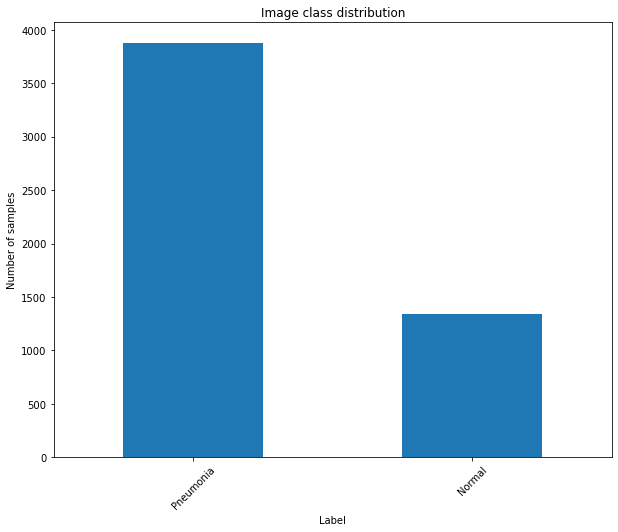

In [18]:
plt.figure(figsize = (10,8))
trainDF.label.value_counts().plot(kind = 'bar')
plt.xticks(ticks = [0,1],labels=['Pneumonia','Normal'],rotation = 45)
plt.xlabel('Label')
plt.ylabel('Number of samples')
plt.title('Image class distribution')
plt.show()

# Images in our training set

Here are 5 pictures of X-Ray's that were diagnosed with pneumonia

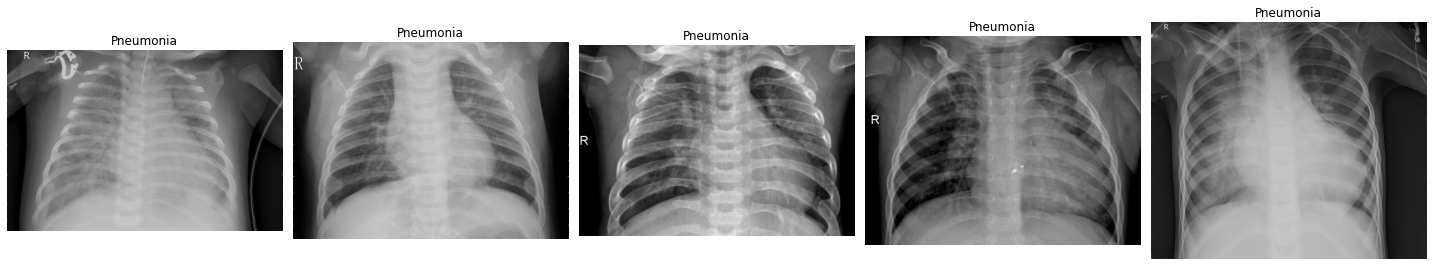

In [19]:
pneumo_pics = (trainDF[trainDF['label']==1]['image'].iloc[:5]).tolist()
#normal_pics = (trainDF[trainDF['label']==0]['image'].iloc[:5]).tolist()
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(pneumo_pics[i])
    #img = plt.imread(os.path(normal_path))
    plt.imshow(img, cmap='gray')
    plt.title("Pneumonia")
    plt.axis('off')
    
plt.tight_layout()

In [20]:
pneumo_pics

[WindowsPath('../data/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1001_bacteria_2932.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1002_bacteria_2933.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1003_bacteria_2934.jpeg')]

And here are 5 pictures of X-Ray's that were diagnosed as normal.

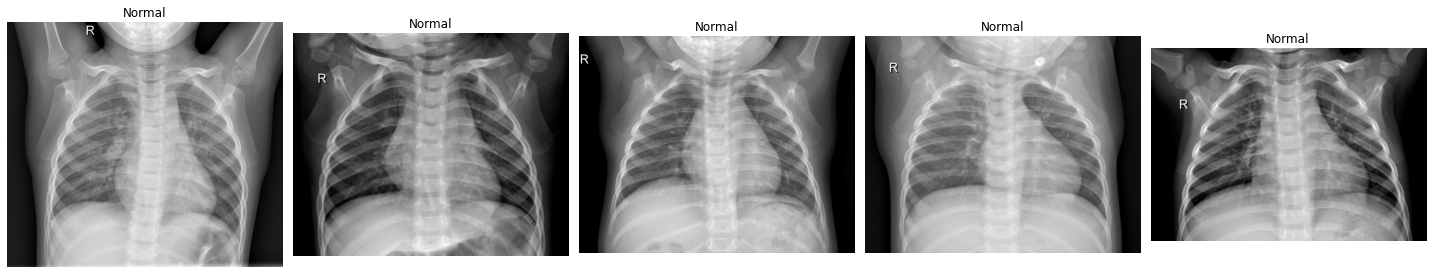

In [21]:
normal_pics = (trainDF[trainDF['label']==0]['image'].iloc[:5]).tolist()
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(normal_pics[i])
    #img = plt.imread(os.path(normal_path))
    plt.imshow(img, cmap='gray')
    plt.title("Normal")
    plt.axis('off')
    
plt.tight_layout()

Lets take a look at a bigger version of a normal image, this time with the grayscale colorbar added

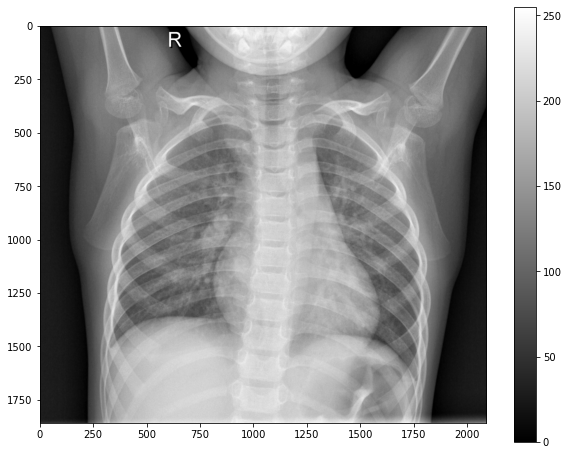

In [22]:
plt.figure(figsize = (10,8))
img = plt.imread(normal_pics[0])
plt.imshow(img,cmap='gray')
plt.colorbar()
plt.show()

In [23]:
img.shape

(1858, 2090)

In [24]:
#Lets see what some of the other image dimensions are. 

for i in range(5):
    img = plt.imread(normal_pics[i])
    print(img.shape)

(1858, 2090)
(1152, 1422)
(1434, 1810)
(1279, 1618)
(1125, 1600)


In [25]:
for i in range(5):
    img = plt.imread(pneumo_pics[i])
    print(img.shape)

(760, 1152)
(768, 1072)
(863, 1244)
(940, 1242)
(1280, 1488)


We will want to include resizing in our preprocessing to account for the differences in image size seen here. 

# set aside validation data

85/15 split (15 for model tuning). We will use the actual test folder data for final model evaluation. 

In [28]:
total = len(train)
train_size = int(0.85*total)
val_size = total - train_size
print(total, train_size, val_size)

5216 4433 783


In [29]:
### maybe
train_data, test_data = torch.utils.data.random_split(train, [train_size, val_size])

another 85/15 split, this time with the 15% set being for training validation. we will add in the 16 validation folder images to this smaller set. 

In [26]:
tot2 = len(train_data)
tr_size = int(0.85*tot2)
v_size = tot2-tr_size
print(tot2,tr_size,v_size)

4433 3768 665


In [30]:
train_data, val_data = torch.utils.data.random_split(train_data, [tr_size, v_size])

In [35]:
train_data, val_data = list(train_data),list(val_data)

In [36]:
type(train_data)
#type(train)

list

In [37]:
trainDF = pd.DataFrame(train_data, columns = ['image','label'],index = None)

In [39]:
trainDF.label.value_counts()

1    2771
0     997
Name: label, dtype: int64

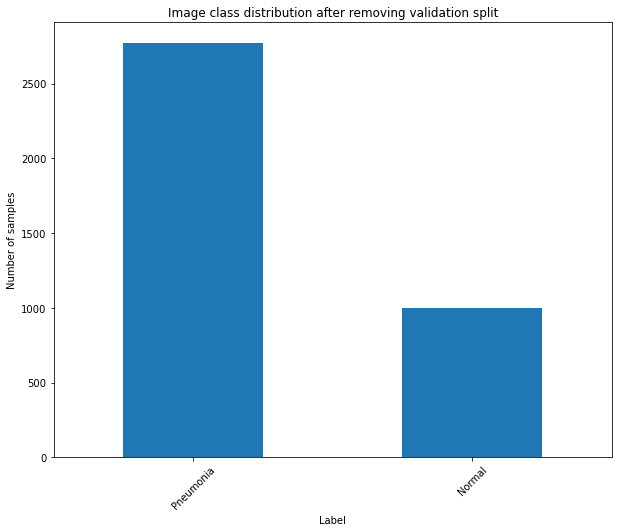

In [41]:
plt.figure(figsize = (10,8))
trainDF.label.value_counts().plot(kind = 'bar')
plt.xticks(ticks = [0,1],labels=['Pneumonia','Normal'],rotation = 45)
plt.xlabel('Label')
plt.ylabel('Number of samples')
plt.title('Image class distribution after removing validation split')
plt.show()

In [49]:
train_data[0][0]

WindowsPath('../data/chest_xray/train/PNEUMONIA/person1717_bacteria_4534.jpeg')

In [52]:
train_data[0][1]

1

In [50]:
copy_dir = Path('../data/augNormal')
new_dir = copy_dir / 'train_subset'

In [61]:
new_testdir = copy_dir / 'test_subset'
new_valdir = copy_dir / 'val_subset'

In [51]:
n_path = new_dir / 'NORMAL'
p_path = new_dir / 'PNEUMONIA'

In [56]:
val_data[0][1]

1

In [57]:
val_data[0][0]

WindowsPath('../data/chest_xray/train/PNEUMONIA/person1159_virus_1944.jpeg')

In [58]:
len(val_data)

665

In [62]:
npN = new_valdir / 'NORMAL'
npP = new_valdir / 'PNEUMONIA'

In [67]:
TPN = new_testdir / 'NORMAL'
TPP = new_testdir / 'PNEUMONIA'

In [64]:
len(test_data)

783

In [66]:
test_data[0][1]

0

In [68]:
for x in test_data:
    src, lab = x[0], x[1]
    jpgfile = src
    if lab == 0:
        shutil.copy(jpgfile, TPN)
    elif lab == 1:
        shutil.copy(jpgfile, TPP)

In [63]:
for x in val_data:
    src, lab = x[0], x[1]
    jpgfile = src
    if lab == 0:
        shutil.copy(jpgfile, npN)
    elif lab == 1:
        shutil.copy(jpgfile, npP)

In [48]:
import glob
import shutil
import os

In [54]:
for x in train_data:
    src, lab = x[0], x[1]
    jpgfile = src
    if lab == 0:
        shutil.copy(jpgfile, n_path)
    elif lab == 1:
        shutil.copy(jpgfile, p_path)

    for x in train_data:
        src, lab = x[0], x[1]
        jpgfile = src
        shutil.copy(jpgfile, new_dir)


    src_dir = "your/source/dir"
    dst_dir = "your/destination/dir"
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir)

In [22]:
#train_raw = datasets.ImageFolder(train_dir)

In [43]:
val_16 = []
vN = val_dir / 'NORMAL'
vP = val_dir / 'PNEUMONIA'

for x in normal:
    val_16.append((x,0))
for y in pneumo:
    val_16.append((y,1))

In [23]:
#val_16 = datasets.ImageFolder(val_dir)

In [24]:
total = len(train_raw)

In [25]:
total

5216

In [ ]:
train_raw = datasets.ImageFolder(new_dir)


# Image Augmentations

We will use the torchvision transforms library in this section. There are 2 main objectives here. The first is to balance our classes, that is to use augmentations to increase the number of "normal" class images in our training data to match the number of "pneumonia" class images. The second is to resize the images and normalize their channel values to have consistent data to train our network on. For now we will use the mean and std from imagenet for normalization ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), but may play with this in the tuning stage of the project. 

## Class Imbalance

There are several ways we could go about dealing with the class imbalance. We could generate more "Normal" images, and add them in to our current normal images before training. 
Alternatively, we could write a function to generate images as we go on a batch by batch basis, or change the weighting in the loss function used.

For now we will try generating more "normal" images using augmentations. In our training set, there are 3875 "Pneumonia" images and 1341 "Normal" images. his means we need more than twice the number of images currently availible. So, we will use 2 sets of transform compositions to augment the original training data. For the sake of avoiding duplicates/unrepresentative data, I didn't want to perform the same transforms twice in a row. Because we are dealing with medical images, some augmentation techniques wouldn't make much sense (i.e. horizontal reflections), as such an image would never be possible from scanning a human body. I also didn't want to blur, crop or rotate the images too dramatically, as any future data probably wouldn't be well represented by this. 


In [76]:
class_names = ['NORMAL', 'PNEUMONIA']

### First set of transforms

    #https://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209/4
    class DatasetFromSubset(Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform

        def __getitem__(self, index):
            x, y = self.subset[index]
            if self.transform:
                x = self.transform(x)
            return x, y

        def __len__(self):
            return len(self.subset)

In [78]:
normal_transforms = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.GaussianBlur(kernel_size=(5, 9),sigma=(0.5, 1.0)),
        transforms.ColorJitter(hue=0),
        #transforms.RandomResizedCrop(224),
        transforms.RandomRotation(2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [47]:
train_data[0]

(WindowsPath('../data/chest_xray/train/PNEUMONIA/person1717_bacteria_4534.jpeg'),
 1)

In [79]:
extra_normal1 = ImageFolder(new_dir, transform = normal_transforms)

In [80]:
extra_normal1[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [81]:
type(extra_normal1)

torchvision.datasets.folder.ImageFolder

In [82]:
len(extra_normal1)

3768

Lets take a look at a batch of these images to see if these transforms create what we want to add. 

In [83]:
def imshow(inp, figsize = (20,20),title=None):
    """Imshow for Tensor.
    This function is modified from the PyTorch transfer learning tutorial notebook
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [84]:
normDL1 = DataLoader(extra_normal1, batch_size = 16, shuffle = True, num_workers = 4)

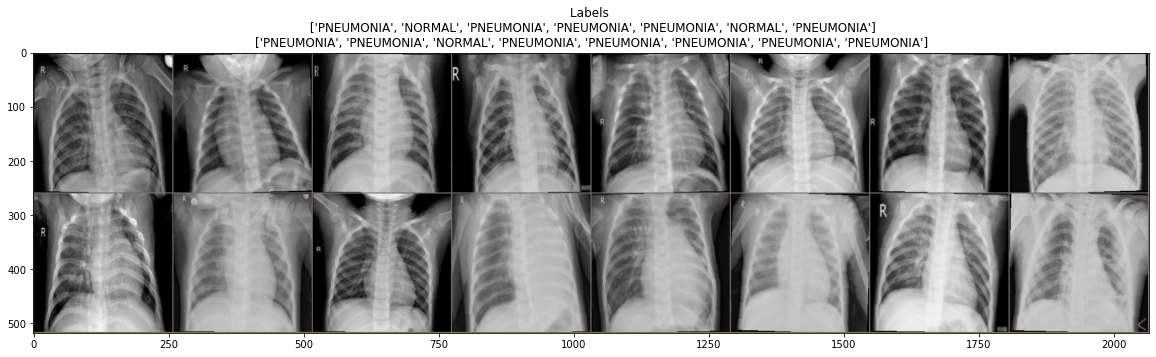

In [85]:
inputs,classes = next(iter(normDL1))
out = torchvision.utils.make_grid(inputs)
#Split the title

batchnames = [class_names[x] for x in classes]

imshow(out, title = "Labels \n "+ str(batchnames[:7])+"\n"+str(batchnames[8:]))

These look pretty good, they aren't "too" augmented (i.e. no big cropping, no reflections etc) so they still look like plausible x ray images, but the gaussian blur, brightness/exposure adjustments, and minor rotations should help bolster our training data. 

Note that because of the way we have our directories set up, we are going to create extra pnemo images as well, which we will need to separate when we re-load the saved images. 

Lets look at what a single element of our imagefolder looks like. 

In [ ]:
extra_normal1[0]

And lets double check that we know where the break between the classes are. 

In [32]:
extra_normal1[1340][-1]

0

In [33]:
extra_normal1[1341][-1]

1

Classes are stored as the last element with [:1341] being "normal and [1341:] being "pneumonia".

### Second set of transforms

In [34]:
normal_transforms2 = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.GaussianBlur(kernel_size=(5, 9),sigma=(1.0, 1.5)),
       # transforms.ColorJitter(hue=0),
        transforms.RandomAffine(degrees = 5),
        #transforms.RandomResizedCrop(224),
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [35]:
extra_normal2 = datasets.ImageFolder(train_dir, transform = normal_transforms)

In [36]:
normDL2 = DataLoader(extra_normal1, batch_size = 16, shuffle = True, num_workers = 4,pin_memory=True)

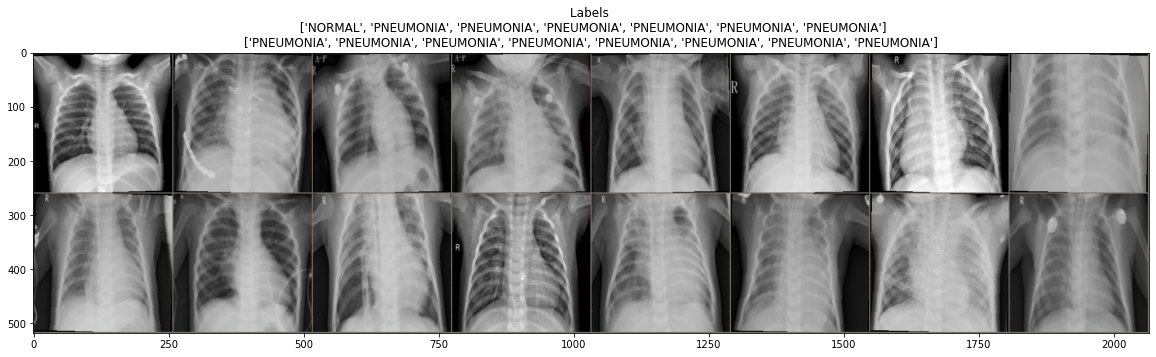

In [37]:
inputs,classes = next(iter(normDL2))
out = torchvision.utils.make_grid(inputs)

batchnames = [class_names[x] for x in classes]

imshow(out, title = "Labels \n "+ str(batchnames[:7])+"\n"+str(batchnames[8:]))

In [38]:
extra_normal1.classes

['NORMAL', 'PNEUMONIA']

save_image(img1, 'img1.png')

In [136]:
#normDL = DataLoader(extra_normal1, batch_size = 16, shuffle = True, num_workers = 4,pin_memory=True)

In [113]:
#type(train_data)

torchvision.datasets.folder.ImageFolder

### Final set of transforms for all training data

In [87]:

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.GaussianBlur(kernel_size=(5, 9),sigma=(0.1, 2.0)),
        #transforms.ColorJitter(hue=0),
        #transforms.RandomResizedCrop(224),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }


In [41]:
train_data = datasets.ImageFolder(train_dir, transform = data_transforms['train'])
#test_data = datasets.ImageFolder(test_dir, transform = data_transforms['test'])

In [88]:
train_data = ImageFolder(new_dir, transform = data_transforms['train'])
val_data = ImageFolder(new_valdir,transform = data_transforms['val'])

In [91]:
test_data = ImageFolder(new_testdir, transform = data_transforms['test'])

In [89]:
train_data.classes

['NORMAL', 'PNEUMONIA']

In [90]:
class_names = train_data.classes

In [44]:
3875-1341-1341

1193

In [45]:
type(train_data)

torchvision.datasets.folder.ImageFolder

In [46]:
type(extra_normal1)

torchvision.datasets.folder.ImageFolder

### Adding the extra "normal" images back in
Now we will subset ~ 2500 normal images from the augmented data and mix them back in to our training set. 

In [47]:
e1 = torch.utils.data.Subset(extra_normal1, list(range(1341)))

In [48]:
type(e1)

torch.utils.data.dataset.Subset

In [55]:
e2 = torch.utils.data.Subset(extra_normal2, list(range(1193)))

In [56]:
AUGdataset = ConcatDataset([train_data, e1, e2])

In [57]:
len(AUGdataset)

7750

In [58]:
AUGdataset[0][-1]

0

In [59]:
#takes a while so will keep commented out in future runs
AUGcounts = [AUGdataset[i][-1] for i in range(len(AUGdataset))]

In [62]:
AUGco = dict(Counter(AUGcounts))

In [63]:
AUGco

{0: 3875, 1: 3875}

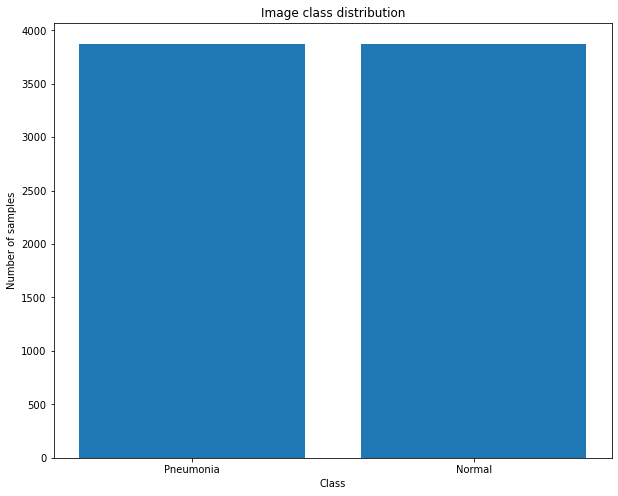

In [67]:
plt.figure(figsize = (10,8))
plt.bar(AUGco.keys(),AUGco.values())
plt.xlabel('Class')
plt.xticks(ticks = [0,1],labels=['Pneumonia','Normal'])
plt.ylabel('Number of samples')
plt.title('Image class distribution')
plt.show()

In [146]:
valdo = [val_data[i][-1] for i in range(len(val_data))]

In [147]:
valco = dict(Counter(valdo))

In [148]:
valco

{0: 166, 1: 499}

In [149]:
testdo = [test_data[i][-1] for i in range(len(test_data))]
testco = dict(Counter(testdo))
testco

{0: 178, 1: 605}

In [ ]:
train_raw = ImageFolder(train_dir)
val_raw = ImageFolder

## Preprocessing & Modeling <a class="anchor" id="chapter2"></a>

We will employ transfer learning with a CNN trained on imagenet data. 

The way I am going to divide the data is to save the 624 "test" images for model evaluation/selection, and do an 80/20 split on the training data (now 7748 images), with the smaller split being our validation set to use during training. 

### Creating dataloaders for our datasets

In [71]:
total = len(AUGdataset)
print(total)

7750


In [72]:
train_size = int(0.8 * total)
val_size = total - train_size
train_data, val_data = torch.utils.data.random_split(AUGdataset, [train_size, val_size])

In [ ]:
torch.utils.data.WeightedRandomSampler(weights, num_samples = 7750, replacement=True, generator=None)

In [92]:
dataset_sizes = {'train': len(train_data), 'val':len(val_data),'test': len(test_data)}

In [93]:
dataset_sizes

{'train': 3768, 'val': 665, 'test': 783}

In [94]:
trainDL = DataLoader(train_data, batch_size = 16, shuffle = True, num_workers = 6,pin_memory=True)

In [95]:
valDL = DataLoader(val_data, batch_size = 16, shuffle = True, num_workers = 6, pin_memory = True)

In [96]:
testDL = DataLoader(test_data, batch_size = 16, shuffle = True, num_workers = 6, pin_memory = True)

In [97]:
dataloaders = {'train': trainDL, 'val':valDL, 'test':testDL}

Lets take a look at what a single batch from our training data looks like

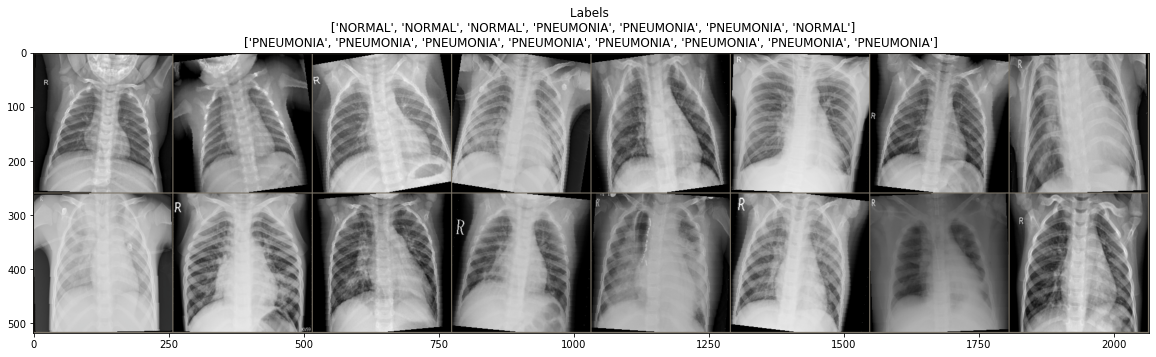

In [98]:
# Get a batch of training data
inputs, classes = next(iter(trainDL))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#Split the title

batchnames = [class_names[x] for x in classes]

imshow(out, title = "Labels \n "+ str(batchnames[:7])+"\n"+str(batchnames[8:]))

# Model Training 

The following 2 functions are modified from the pytorch transfer learning tutorial documentation which can be found at the following link. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html



In [99]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [100]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [101]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            print(dataset_sizes['phase'])

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Transfer Learning with Resnet18

In [102]:
#load in the pretrained model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [153]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize = (8,8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.plot(figsize = (8,8))
                ax.axis('off')
                ax.set_title('Actual: {}             predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                #ax.set_title(f'predicted: {class_names[preds[j]]}')
                plt.xlabel(labels[j])
                imshow(inputs.cpu().data[j],figsize = (4,4))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Here is where we begin training

In [104]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.1676 Acc: 0.9323
val Loss: 0.1060 Acc: 0.9474

Epoch 1/9
----------
train Loss: 0.0872 Acc: 0.9660
val Loss: 0.0439 Acc: 0.9925

Epoch 2/9
----------
train Loss: 0.0535 Acc: 0.9830
val Loss: 0.0452 Acc: 0.9789

Epoch 3/9
----------
train Loss: 0.0446 Acc: 0.9817
val Loss: 0.0494 Acc: 0.9805

Epoch 4/9
----------
train Loss: 0.0385 Acc: 0.9859
val Loss: 0.0295 Acc: 0.9925

Epoch 5/9
----------
train Loss: 0.0233 Acc: 0.9918
val Loss: 0.0401 Acc: 0.9865

Epoch 6/9
----------
train Loss: 0.0225 Acc: 0.9926
val Loss: 0.0259 Acc: 0.9895

Epoch 7/9
----------
train Loss: 0.0156 Acc: 0.9947
val Loss: 0.0257 Acc: 0.9910

Epoch 8/9
----------
train Loss: 0.0146 Acc: 0.9958
val Loss: 0.0244 Acc: 0.9895

Epoch 9/9
----------
train Loss: 0.0158 Acc: 0.9955
val Loss: 0.0209 Acc: 0.9940

Training complete in 4m 2s
Best val Acc: 0.993985


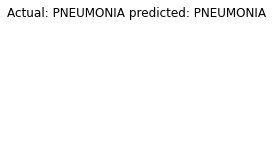

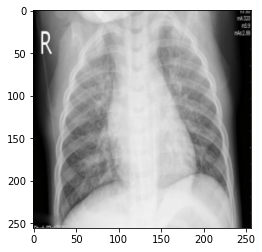

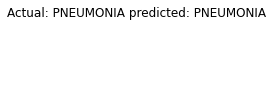

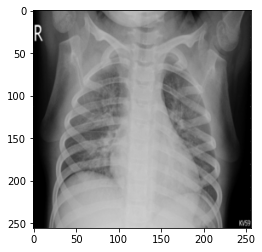

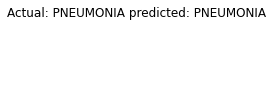

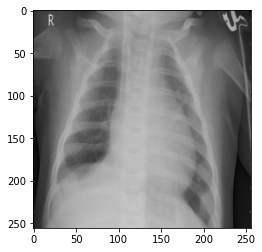

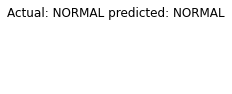

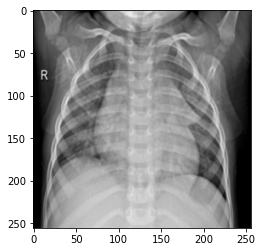

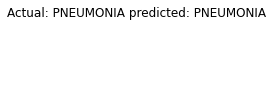

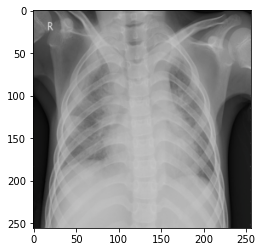

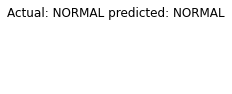

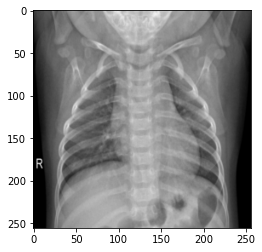

In [154]:
visualize_model(model_ft)

In [108]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.GaussianBlur(kernel_size=(5, 9),sigma=(0.1, 2.0)),
        #transforms.ColorJitter(hue=0),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Metrics

In [ ]:
test_data = ImageFolder(new_testdir, transform = data_transforms['test'])

In [106]:
test_load = DataLoader(test_data, batch_size = 1)

In [107]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for imgs, labels in test_load:
        x_batch, y_batch = imgs.to(device), labels.to(device)
        y_test_pred = model_ft(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [108]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [109]:
len(y_pred_list)

783

In [110]:
from sklearn.metrics import classification_report,accuracy_score


In [111]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       178
           1       1.00      0.99      0.99       605

    accuracy                           0.99       783
   macro avg       0.98      0.99      0.99       783
weighted avg       0.99      0.99      0.99       783



In [112]:
accuracy_score(y_true_list, y_pred_list)

0.9897828863346104

In [113]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

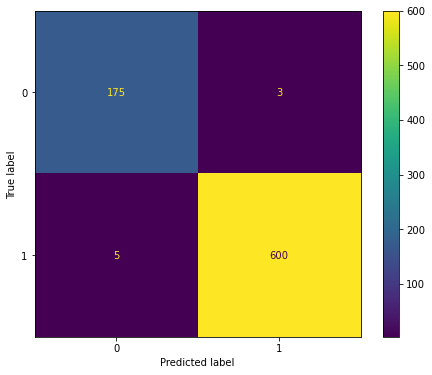

In [114]:
fig, ax = plt.subplots(figsize=(8,6))
cm = confusion_matrix(y_true_list, y_pred_list)
disp = ConfusionMatrixDisplay(cm, display_labels = [0,1])
disp.plot(ax=ax)      

false positives are better than false negatives

In [115]:
f1_score(y_true_list, y_pred_list)

0.9933774834437086

In [116]:
torch.save(model_ft.state_dict(), '../models/model111_no_aug')

## Freezing the network except for the final layer. 

In [118]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [119]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.2886 Acc: 0.8787
val Loss: 0.1890 Acc: 0.9098

Epoch 1/9
----------
train Loss: 0.1979 Acc: 0.9159
val Loss: 0.1434 Acc: 0.9353

Epoch 2/9
----------
train Loss: 0.1781 Acc: 0.9275
val Loss: 0.1241 Acc: 0.9444

Epoch 3/9
----------
train Loss: 0.1696 Acc: 0.9318
val Loss: 0.1629 Acc: 0.9338

Epoch 4/9
----------
train Loss: 0.1480 Acc: 0.9421
val Loss: 0.1324 Acc: 0.9474

Epoch 5/9
----------
train Loss: 0.1547 Acc: 0.9360
val Loss: 0.1144 Acc: 0.9459

Epoch 6/9
----------
train Loss: 0.1688 Acc: 0.9323
val Loss: 0.1179 Acc: 0.9549

Epoch 7/9
----------
train Loss: 0.1359 Acc: 0.9453
val Loss: 0.1086 Acc: 0.9504

Epoch 8/9
----------
train Loss: 0.1412 Acc: 0.9411
val Loss: 0.1141 Acc: 0.9549

Epoch 9/9
----------
train Loss: 0.1317 Acc: 0.9522
val Loss: 0.1166 Acc: 0.9549

Training complete in 3m 53s
Best val Acc: 0.954887


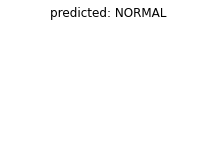

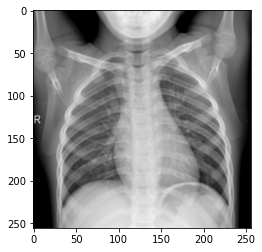

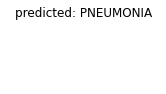

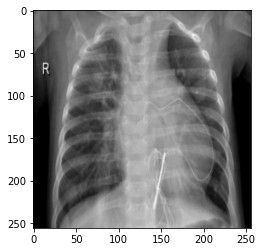

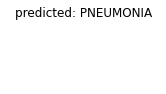

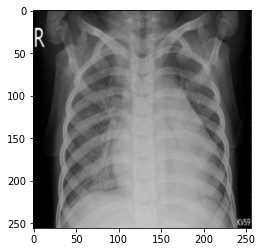

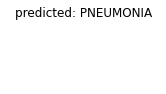

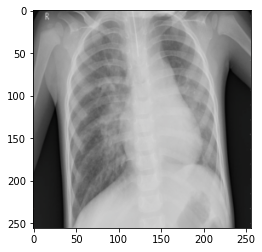

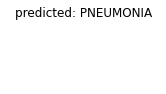

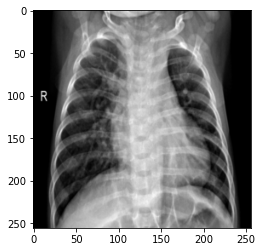

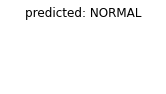

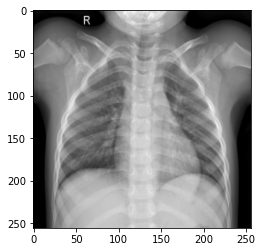

In [120]:
visualize_model(model_conv)


In [130]:
final_data = ImageFolder(test_dir,transform = data_transforms['test'])

In [157]:
test_load = DataLoader(test_data,batch_size = 1,shuffle = True)

In [140]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for imgs, labels in test_load:
        x_batch, y_batch = imgs.to(device), labels.to(device)
        y_test_pred = model_conv(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [141]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [142]:
len(y_pred_list)

624

In [143]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.98      0.68      0.80       234
           1       0.84      0.99      0.91       390

    accuracy                           0.87       624
   macro avg       0.91      0.83      0.85       624
weighted avg       0.89      0.87      0.87       624



In [144]:
accuracy_score(y_true_list, y_pred_list)

0.8733974358974359

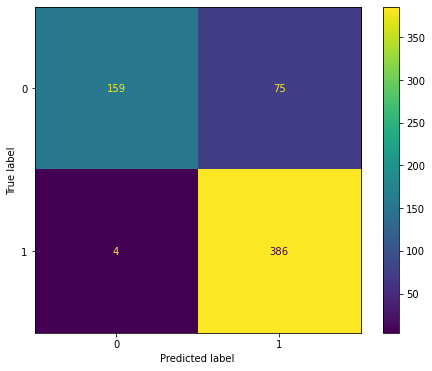

In [145]:
fig, ax = plt.subplots(figsize=(8,6))
cm = confusion_matrix(y_true_list, y_pred_list)
disp = ConfusionMatrixDisplay(cm, display_labels = [0,1])
disp.plot(ax=ax)      

false positives are better than false negatives

In [160]:
final_final = ImageFolder(val_dir,transform = data_transforms['test'])

In [161]:
test_load = DataLoader(final_final,batch_size = 1,shuffle = True)

In [138]:
f1_score(y_true_list, y_pred_list)

0.8754208754208754

In [129]:
torch.save(model_ft.state_dict(), '../models/model111_no_aug_frozen')

In [150]:
#odel = torch.load("train_5.pth")

def test(model, device, test_loader,verbose = True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to('cuda'), target.to('cuda')
            output = model(data)
            #test_loss += f.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            if verbose == True:
                print(pred, target)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
         correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


#test(model, 'cuda', testloader)

In [162]:
test(model_ft,device, test_load)

tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')

Test set: Accuracy: 14/16 (88%)



In [163]:
test(model_conv,device,test_load)

tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([1], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([0], device='cuda:0')
tensor([[0]], device='cuda:0') tensor([0], device='cuda:0')

Test set: Accuracy: 15/16 (94%)



In [ ]:
torch.utils.data.WeightedRandomSampler(weights, num_samples = 7750, replacement=True, generator=None)

In [ ]:
#https://marekpaulik.medium.com/imbalanced-dataset-image-classification-with-pytorch-6de864982eb1
def load_data(self):
    train_full = torchvision.datasets.ImageFolder(self.data_dir, transform=self.Transform)
    train_set, val_set = random_split(train_full, [math.floor(len(train_full)*0.8), math.ceil(len(train_full)*0.2)])

    self.train_classes = [label for _, label in train_set]
    if self.sample:
        # Need to get weight for every image in the dataset
        class_count = Counter(self.train_classes)
        class_weights = torch.Tensor([len(self.train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
        # Can't iterate over class_count because dictionary is unordered

        sample_weights = [0] * len(train_set)
        for idx, (image, label) in enumerate(train_set):
            class_weight = class_weights[label]
            sample_weights[idx] = class_weight

        sampler = WeightedRandomSampler(weights=sample_weights,
                                        num_samples = len(train_set), replacement=True)  
        train_loader = DataLoader(train_set, batch_size=self.batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)

    val_loader = DataLoader(val_set, batch_size=self.batch_size)

    return train_loader, val_loader

    https://pytorch.org/vision/stable/feature_extraction.html

https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py

In [ ]:
#https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)